In [1]:
import enzyASM
import numpy as np
import pandas as pd
from rdkit import Chem
from aqme.qprep import qprep

### 1. Load PDB structure

In [2]:
pdb_code = '3zr4'
data = enzyASM.download(pdb_code)

http://www.pdb.org/pdb/download/downloadFile.do?fileFormat=pdb&compression=NO&structureId=3zr4


In [3]:
pdb_file = '3zr4.pdb'

### 2. Let's learn about this pdb file

In [4]:
enzyASM.PDB_file_info(pdb_file)

Information on PDB file: 3zr4.pdb
Hydrogens are not present. Structure will be automatically protonated during truncation step.
----------------------------------------------
Total number of atoms: 10728
Water molecules: 204
Ions: 0
Standard amino acid residues: 1333
----------------------------------------------
The following 9 ligands were detected:
1:
Chain: A  Name: GOL  ID: 1202
.........
2:
Chain: B  Name: GLN  ID: 1205
.........
3:
Chain: B  Name: GOL  ID: 1201
.........
4:
Chain: B  Name: GOL  ID: 1202
.........
5:
Chain: C  Name: GOL  ID: 1254
.........
6:
Chain: D  Name: GLN  ID: 1205
.........
7:
Chain: D  Name: GOL  ID: 1201
.........
8:
Chain: E  Name: GOL  ID: 1254
.........
9:
Chain: E  Name: GOL  ID: 1255
.........
----------------------------------------------


### 3. Define a catalytic center for the active site model
- Here we choose the L-Gln ligand from chain B.
- It is actually best to do this first if we are going to protonate with obabel because obabel will think the GLN ligand is part of the protein and changes its information making it more difficult to define as the catalytic center. 
- Alternatively, the structure could be protonated another way, or the ligand information can be manually changed in the PDB. 

In [5]:
substrate_mol, protein_mol = enzyASM.catalytic_center(pdb_file,catalytic_center=[1205,'GLN','B'],definition=['res_number','res_name','chain'])

Catalytic center contains 10 atoms.
Structure saved as catalytic_center.pdb


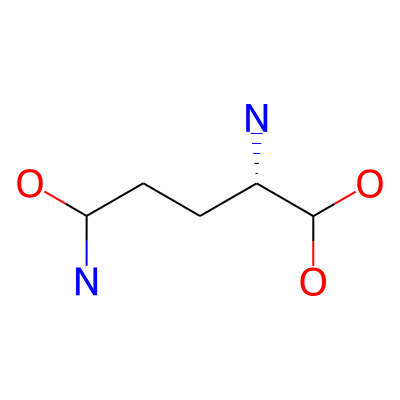

In [6]:
enzyASM.show_mol(substrate_mol)

### 4. Define the active site by a cutoff distance from the catalytic center
- This is done in two stages: Stage 1 the distance is measured from the centroid of the catalytic center. Whenever an atom of a residue is within the cutoff, the entire residue is added to the centroid_shell_mol object. Stage 2 the same process happens, however a significant number of residues have already been removed from the first stage, so now the distance between all remaining atoms and the distance between all catalytic center atoms is measured to narrow the selection down.
- "residues_centroid" and "residues_asm" contain information on what atom from that residue was within the cutoff distance. This can be useful when trying to decide if the side chain or main chain should be kept or truncated (see below). 

In [7]:
%%time

distance_cutoff = 5

centroid_shell_mol, residues_centroid = enzyASM.residue_shell(substrate_mol,distance_cutoff,pdb_file,centroid=True)
active_site_mol, residues_asm = enzyASM.residue_shell(substrate_mol,distance_cutoff,base_mol=centroid_shell_mol,centroid=False)

Initial pass results in 153 atoms.
Final pass results in 135 atoms.
Structure saved as active_site_radius_5.pdb
CPU times: user 15 s, sys: 168 ms, total: 15.2 s
Wall time: 15 s


In [8]:
pd.DataFrame(residues_asm)

,Residue Name,Residue Number,Residue Atom,Atom Type,Residue Chain
0,GLN,123,CD,Sidechain,A
1,GLN,123,OE1,Sidechain,A
2,GLY,50,O,Backbone,B
3,VAL,51,N,Backbone,B
4,VAL,51,CA,Backbone,B
...,...,...,...,...,...
69,GLN,1205,NE2,Sidechain,B
70,GLN,1205,OXT,Sidechain,B
71,HOH,2024,O,Backbone,B
72,HOH,2030,O,Backbone,B


### Step 5. (optional) Remove ancillary residues
- If the sidechain is pointing away from the active site, especially if it is big and bulky, it might not be important to keep in the model, in which case it would be best to remove in order to keep your total number of atoms low. 
- This should be done with caution, however, since the residue could be involved in other interactions that influence direct interactions along the reaction coordinate. 

In [9]:
remove_sidechain = []

for resnum in np.unique(residues_asm['Residue Number']):
    sc = 0
    bb = 0
    atoms = np.where(np.array(residues_asm['Residue Number'])==resnum)
    for atom in atoms[0]:
        if residues_asm['Residue Name'][atom] == 'GLY':
            sc = 2
            continue
        if residues_asm['Residue Name'][atom] == 'HOH':
            sc = 2
            continue
        if residues_asm['Atom Type'][atom] == 'Sidechain':
            sc += 1
    if sc < 2:
        remove_sidechain.append(resnum)
print(remove_sidechain)

[53, 54, 176]


### Step 6. Truncate the model
- More improvements, such as additional truncation schemes, can be expected in future versions
- Currently, the code defaults to a "CA_terminal" scheme, in which only terminal or lone residues are truncated at the C-alpha. For example, if the following residues are included in the cutoff distance, 40–41–42–43 50, the the N-terminus of residue 40 will be removed, leaving the C-alpha, and the C-terminus of residue 43 will be removed, leaving the C-alpha, and the N- and C-termini of residue 50 will be removed, leaving onlt the C-alpha.
- One "feature" of the current truncation function is that the atoms bonded to CA that are removed get replaced with Hydrogens, but the bond length does not change. This shouldn't be too much of an issue as the bond length will quickly adjust during any energy minimization step.

In [10]:
truncated_active_site_mol, constrain_list = enzyASM.truncate_new(active_site_mol,scheme='CA_terminal', skip_resnumbers=[1205], remove_sidechains=remove_sidechain,radius=distance_cutoff)

Final active site model contains 109 atoms.
Structure saved as truncated_active_site_radius_5.pdb


### Step 7. Protonate your model
- The enzyASM code uses the obabel protonation function, which also allows you to define the pH, which is handy. However, it should be noted that obabel might change some PDB Residue Info, such as the chain and residue ID. This could cause issues if you are trying to specify that certain residue numbers should be removed during truncation, but you end up referring to the wrong residue numbers. You could either 1) use the enzyASM.obabel_protonate() function at the start, with the inital PDB so you know what residue numbers you are using to define the catalytic center, 2) protonate with your own preferred method, or (recommended) 3) use enzyASM.obabel_protonate() after truncation to complete your model. This last method is shown here. 

In [11]:
enzyASM.obabel_protonate('truncated_active_site_radius_5.pdb')

Protonated structure saved as truncated_active_site_radius_5_protonated.pdb


### Step 8. Generate QM input file for geometry optimization

In [12]:
chrg = 0

previous_res = None
for atom in truncated_active_site_mol.GetAtoms():
    current_res = (enzyASM.res_info(atom,'chain'),enzyASM.res_info(atom,'res_name'),enzyASM.res_info(atom,'res_number'))
    if current_res == previous_res:
        continue
    previous_res = current_res
    if enzyASM.res_info(atom,'res_name') in ["GLU","ASP"]:
        chrg -= 1
    if enzyASM.res_info(atom,'res_name') in ["ARG","LYS","HIP"]:
        chrg += 1

In [13]:
freeze_atoms = ''
for atom in constrain_list:
    freeze_atoms += 'X {} F \n'.format(atom)

In [14]:
qprep(program="gaussian",qm_input="wb97xd 6-31g* opt=modredundant freq=noraman",qm_end=freeze_atoms,
      files='truncated_active_site_radius_5.pdb',charge=chrg,nprocs=16,mem="32GB",suffix='geom_opt')

AQME v 1.4.1 2023/05/15 20:37:55 
Citation: AQME v 1.4.1, Alegre-Requena, J. V.; Sowndarya, S.; Perez-Soto, R.; Alturaifi, T. M.; Paton, R. S., 2022. https://github.com/jvalegre/aqme


o  truncated_active_site_radius_5 successfully processed at /Users/heidiklem/Desktop/Graduate School/Research-projects/enzyme-active-site-modeling/cheminformatics_tutorial/QCALC


Time QPREP: 0.21 seconds


